Welcome to my data analysis project! In this project, we will be analyzing the "Beer Reviews" dataset from Kaggle, uploaded by user "Datadoume". This dataset contains data from ~1.5 million beer reviews from the website "Beer Advocate". Using the data available, we're going to try and analyze the following question: Can we identify trends in consumers' beer preferences? First, let's pull the dataset from Kaggle. 

In [1]:
%%capture
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
# Download latest version
path = kagglehub.dataset_download("rdoume/beerreviews", path='beer_reviews.csv', force_download = True)

beer = pd.read_csv(path)

100%|██████████| 27.4M/27.4M [00:05<00:00, 5.36MB/s]


Let's take a quick look at our data.

In [3]:
beer.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


We can see that each row represents a review ranking a beer on several qualities including an overall score. We also have some basic information about each beer reviewed, such as its type and the brewery producing the beer. Finally, we have some metadata: the date the review was posted, the username of the the user who posted the review, and unique identifiers for the breweries/beers. For the purposes of our analysis, we'll keep all the columns since they could all be useful.

Now let's see how many rows have missing values.

In [4]:
#sum rows with one or more null values
beer.isna().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

We can see from the above output that around 68000 rows have one or more null values and most of the missing values are the ABV (alcohol by volume). Since the number of rows with null values is low compared to the size of the  data set, in this case, we'll opt to discard the null values (we are going to use ABV in our analysis).

In [5]:
#remove nulls
beer = beer[-beer.isna().any(axis=1)]

We'll also look for duplicates in the data.

In [6]:
beer.duplicated().sum()

np.int64(0)

Looks like we're good; no duplicates. At this point, we're ready to begin doing some preliminary analysis of the data. Let's take a look at the review scores first.

In [7]:
#subset data
cols = ["review_overall", "review_aroma", "review_appearance",
        "review_palate", "review_taste"]
round(beer[cols].describe(), 2)

,review_overall,review_aroma,review_appearance,review_palate,review_taste
count,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00
mean,3.82,3.75,3.85,3.75,3.80
std,0.72,0.70,0.61,0.68,0.73
min,0.00,1.00,0.00,1.00,1.00
25%,3.50,3.50,3.50,3.50,3.50
50%,4.00,4.00,4.00,4.00,4.00
75%,4.50,4.00,4.00,4.00,4.50
max,5.00,5.00,5.00,5.00,5.00


/var/folders/b6/811_kpyj6yd5q_vzydsq8cbc0000gn/T/ipykernel_55905/3967134386.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


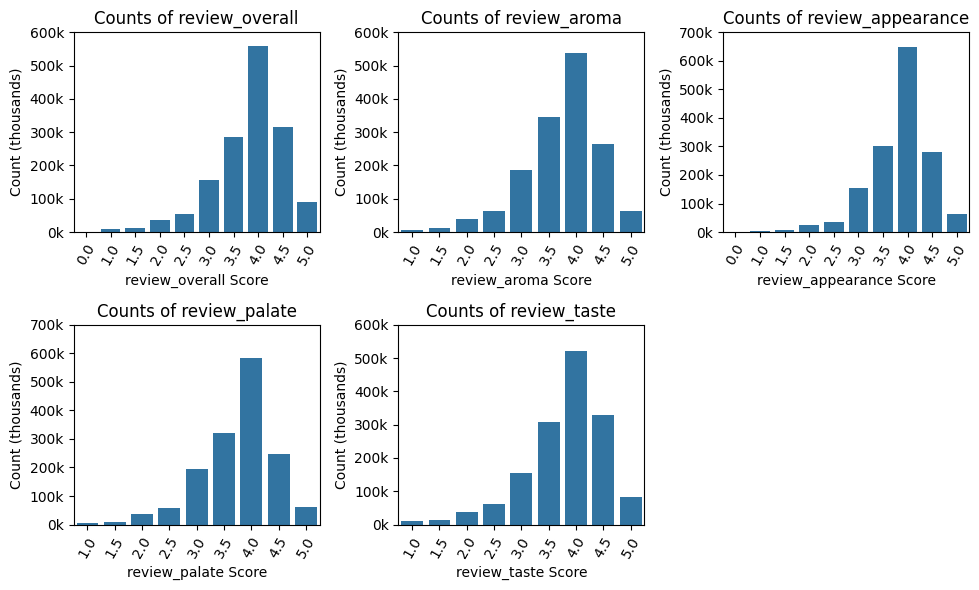

In [8]:
#create a subplots figure + axes
fig, axes = plt.subplots(2,3, figsize=(10,6))
#makes axes 1D
axes = axes.flatten()
#loop over axes and plot
for i in range(5):
        ax = axes[i]
        key = cols[i]
        sb.countplot(data=beer, x=cols[i], ax=ax)
        ax.tick_params(axis='x', rotation=60)
        ax.set_title(f'Counts of {key}')
        yticks = ax.get_yticks()
        ylabels = [f'{int(tick/1000)}k' for tick in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)
        ax.set_ylabel('Count (thousands)')
        ax.set_xlabel(f'{key} Score')
#show results
fig.tight_layout()
fig.delaxes(axes[5])
fig.show()

We can see from the above results that the distribution for each score is similar - 4.0 is the most common score, with scores of 5.0 or 2.5 and below being quite uncommon. All the score distributions exhibit left skew. Let's look at ABV now.

In [9]:
#perform basic analysis at ABV data
round(beer['beer_abv'].describe(), 2)

count    1518478.00
mean           7.04
std            2.32
min            0.01
25%            5.20
50%            6.50
75%            8.50
max           57.70
Name: beer_abv, dtype: float64

We can see that there is a large range between the maximum and minimum values. Let's take a closer look at what a "typical" ABV value looks like.

In [10]:
quants = beer['beer_abv'].quantile([.5,.95])
quants

0.50     6.5
0.95    11.0
Name: beer_abv, dtype: float64

We can see that 90% of beers have ABV values between 0.95 and 11. Let's take a look at the distribution of beers within this range.

Text(0.5, 1.0, 'ABV Counts')

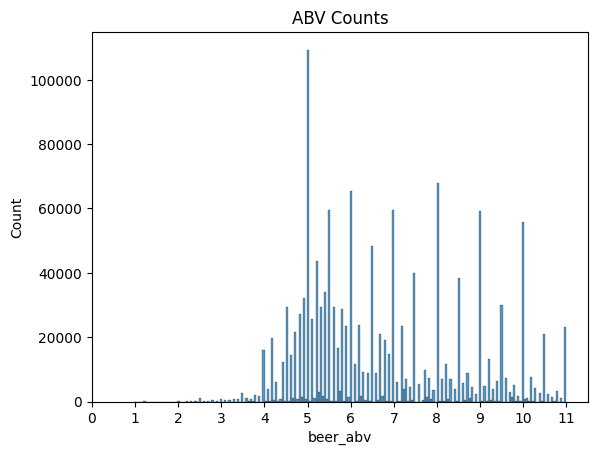

In [11]:
#let's plot the abv counts
ax = sb.histplot(data=beer, x='beer_abv', binrange=(.95,11))
ticks = list(range(12))
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.set_title('ABV Counts')

It appears that beers with an ABV of 5 are the most common. It also appears that whole numbers are better represented. For fun, let's take a look at beer with the highest ABV.

In [14]:
beer.loc[beer['beer_abv'] == max(beer['beer_abv'])]

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
12919,6513,Schorschbräu,1316780901,4.0,4.0,4.0,kappldav123,Eisbock,4.0,3.5,Schorschbräu Schorschbock 57%,57.7,73368


A quick search indicates that this beer is real! Honestly, I would be very curious to try it.